# SABR v2 (Kernel-weighted local calibration) — Demo

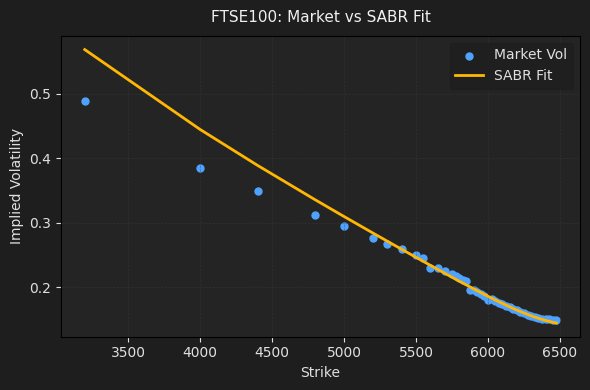

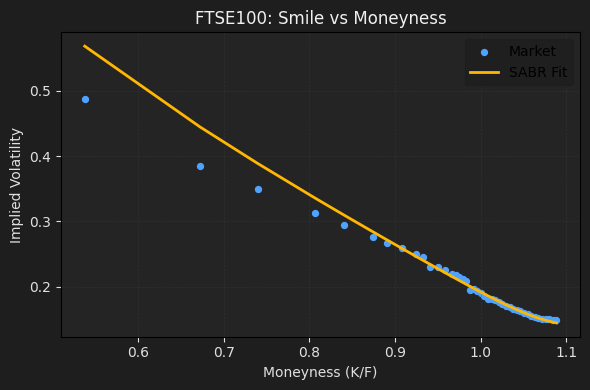

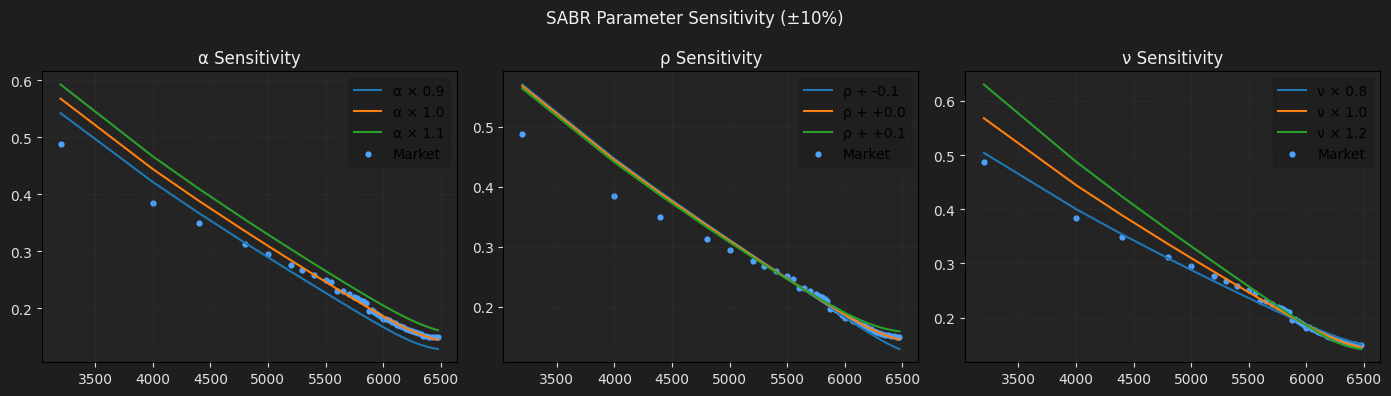

No local parameter data to plot.


In [3]:
import importlib, sabr_pipeline
importlib.reload(sabr_pipeline)
from sabr_pipeline import (load_csv_smile, calibrate_sabr_logmoneyness, compute_model_vols,
                           plot_smile, plot_smile_moneyness, plot_parameter_sensitivity,
                           calibrate_local_sabr_surface, plot_local_parameter_surface)

index_name = 'FTSE100'
df, meta = load_csv_smile(index_name)
F, T = meta['Forward'], meta['T']
strikes = df['Strike'].astype(float).values
market  = df['MarketVol'].astype(float).values

beta = 0.7
calib = calibrate_sabr_logmoneyness(F, T, strikes, market, beta=beta)
model = compute_model_vols(F, T, calib['alpha'], beta, calib['rho'], calib['nu'], strikes)
plot_smile(strikes, market, model, title=f"{index_name}: Market vs SABR Fit")
plot_smile_moneyness(F, strikes, market, model, title=f"{index_name}: Smile vs Moneyness")
plot_parameter_sensitivity(F, T, strikes, calib, beta, market)

local_params = calibrate_local_sabr_surface(F, T, strikes, market, beta, global_prior=calib,
                                            h=0.08, lam_prior=(2e-3,2e-3,2e-3), min_points=6)
plot_local_parameter_surface(local_params, smooth=True, sg_window=9, sg_poly=3)

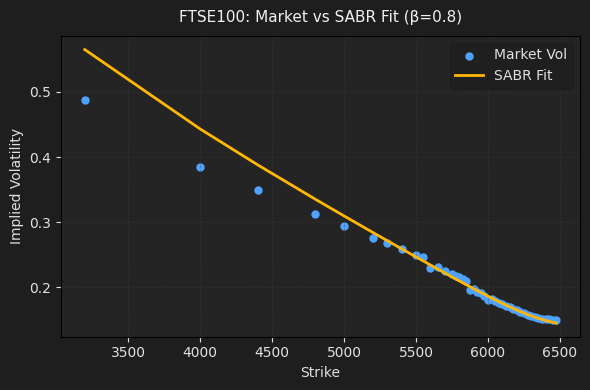

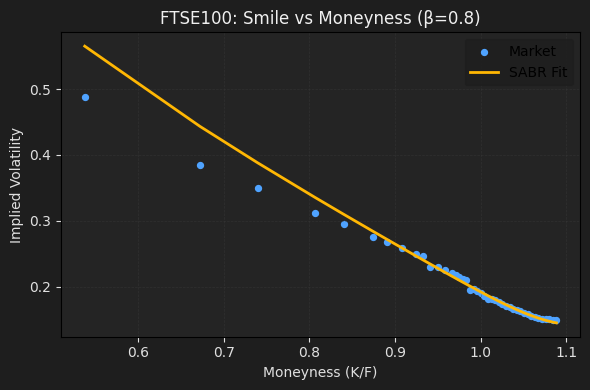

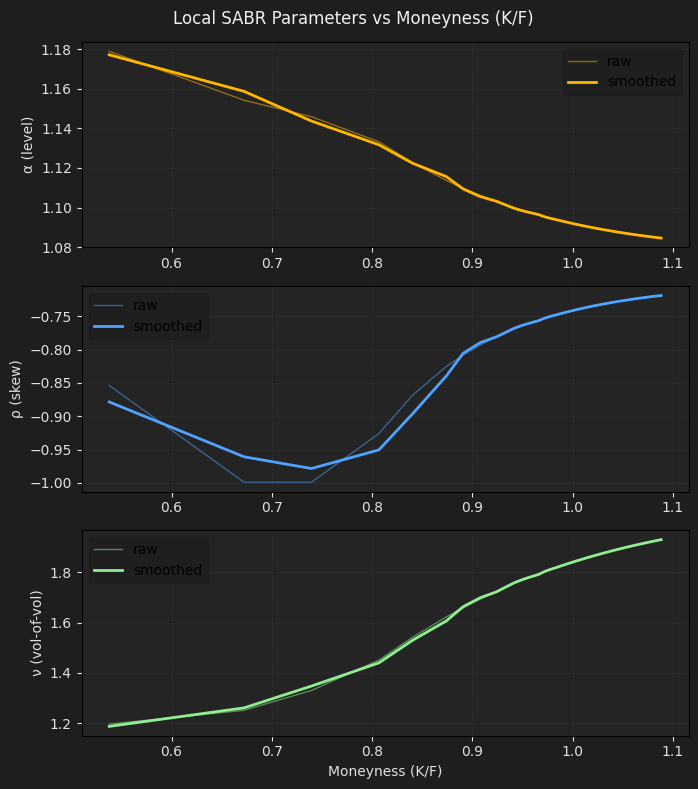

In [4]:
# --- 1️⃣ Reload the latest SABR pipeline ---
import importlib, sabr_pipeline
importlib.reload(sabr_pipeline)

from sabr_pipeline import (
    load_csv_smile, 
    calibrate_sabr_logmoneyness, 
    compute_model_vols,
    plot_smile, 
    plot_smile_moneyness,
    plot_parameter_sensitivity,
    calibrate_local_sabr_surface,
    plot_local_parameter_surface
)

# --- 2️⃣ Load market data and global calibration ---
index_name = 'FTSE100'   # or 'S&P500', 'EUROSTOXX50'
df, meta = load_csv_smile(index_name)

F = meta['Forward']
T = meta['T']
strikes = df['Strike'].astype(float).values
market  = df['MarketVol'].astype(float).values
beta = 0.8

calib = calibrate_sabr_logmoneyness(F, T, strikes, market, beta)
model = compute_model_vols(F, T, calib['alpha'], beta, calib['rho'], calib['nu'], strikes)

plot_smile(strikes, market, model, title=f"{index_name}: Market vs SABR Fit (β={beta})")
plot_smile_moneyness(F, strikes, market, model, title=f"{index_name}: Smile vs Moneyness (β={beta})")

# --- 3️⃣ Local (moneyness-based) calibration and plot ---
local_params = calibrate_local_sabr_surface(
    F, T, strikes, market, beta,
    global_prior=calib,       # uses previous global calibration as a reference
    h=0.18,                   # broaden kernel window
    lam_prior=(1e-3,1e-3,1e-3),
    min_points=4
)

plot_local_parameter_surface(local_params, smooth=True, sg_window=9, sg_poly=3)


In [7]:
import importlib, sabr_pipeline
importlib.reload(sabr_pipeline)

from sabr_pipeline import (
    load_csv_smile, calibrate_sabr_logmoneyness, compute_model_vols,
    plot_smile, plot_smile_moneyness,
    calibrate_local_sabr_surface, plot_local_parameter_surface
)
import ipywidgets as w
from IPython.display import display, Markdown

# --- UI Widgets ---
index_dd = w.Dropdown(
    options=['FTSE100', 'S&P500', 'EUROSTOXX50'],
    value='FTSE100',
    description='Index'
)
beta_slider = w.FloatSlider(value=0.8, min=0.0, max=1.0, step=0.05, description='β (elasticity)')
h_slider = w.FloatSlider(value=0.12, min=0.05, max=0.25, step=0.01, description='Kernel width (h)')
smooth_dd = w.Dropdown(
    options=[('Light (retain shape)', 5), ('Moderate', 9), ('Strong', 15)],
    value=5,
    description='Smoothing'
)
btn = w.Button(description='Run Full Calibration', button_style='primary')
out = w.Output()


# --- Main Logic ---
def run_full(_=None):
    out.clear_output()
    idx = index_dd.value
    beta = beta_slider.value
    h = h_slider.value
    sg_window = smooth_dd.value
    
    try:
        with out:
            display(Markdown(f"### 📊 SABR Calibration & Asymptotic Parameter Surface for **{idx}** (β={beta:.2f})"))

            # --- Load Data ---
            df, meta = load_csv_smile(idx)
            F, T = meta["Forward"], meta["T"]
            strikes = df["Strike"].astype(float).values
            market = df["MarketVol"].astype(float).values

            # --- Global Calibration ---
            calib = calibrate_sabr_logmoneyness(F, T, strikes, market, beta)
            model = compute_model_vols(F, T, calib["alpha"], beta, calib["rho"], calib["nu"], strikes)
            display(Markdown(f"**Global Parameters:** α={calib['alpha']:.4f}, ρ={calib['rho']:.4f}, ν={calib['nu']:.4f}, SSE={calib['cost']:.6g}"))

            plot_smile(strikes, market, model, title=f"{idx}: Market vs SABR Fit (β={beta:.2f})")
            plot_smile_moneyness(F, strikes, market, model, title=f"{idx}: Smile vs Moneyness (β={beta:.2f})")

            # --- Local Surface Calibration ---
            local_params = calibrate_local_sabr_surface(
                F, T, strikes, market, beta,
                global_prior=calib,
                h=h,
                lam_prior=(5e-4, 5e-4, 5e-4),
                min_points=5
            )

            if local_params is not None and len(local_params) > 0:
                plot_local_parameter_surface(local_params, smooth=True, sg_window=sg_window, sg_poly=3)
            else:
                display(Markdown("⚠️ No local parameter data to plot — try reducing h."))

    except Exception as e:
        with out:
            display(Markdown(f"**Error:** {e}"))


btn.on_click(run_full)
display(w.VBox([w.HBox([index_dd, beta_slider, h_slider, smooth_dd]), btn, out]))


In [ ]:
import sabr_pipeline
sabr_pipeline._THRESHOLD = 0.005
def _gaussian_kernel(x, x0, h):  # patch only the threshold behavior
    z = (x - x0) / (h + 1e-12)
    return np.exp(-0.5 * z * z)
sabr_pipeline._gaussian_kernel = _gaussian_kernel




import importlib, sabr_pipeline
importlib.reload(sabr_pipeline)

from sabr_pipeline import (
    load_csv_smile, calibrate_sabr_logmoneyness, compute_model_vols,
    plot_smile, plot_smile_moneyness,
    calibrate_local_sabr_surface, plot_local_parameter_surface
)
import ipywidgets as w
from IPython.display import display, Markdown

# --- UI Widgets ---
index_dd = w.Dropdown(
    options=['FTSE100', 'S&P500', 'EUROSTOXX50'],
    value='FTSE100',
    description='Index'
)
beta_slider = w.FloatSlider(value=0.8, min=0.0, max=1.0, step=0.05, description='β (elasticity)')
h_slider = w.FloatSlider(value=0.12, min=0.05, max=0.25, step=0.01, description='Kernel width (h)')
smooth_dd = w.Dropdown(
    options=[('Light (retain shape)', 5), ('Moderate', 9), ('Strong', 15)],
    value=5,
    description='Smoothing'
)
btn = w.Button(description='Run Full Calibration', button_style='primary')
out = w.Output()


# --- Main Logic ---
def run_full(_=None):
    out.clear_output()
    idx = index_dd.value
    beta = beta_slider.value
    h = h_slider.value
    sg_window = smooth_dd.value
    
    try:
        with out:
            display(Markdown(f"### 📊 SABR Calibration & Asymptotic Parameter Surface for **{idx}** (β={beta:.2f})"))

            # --- Load Data ---
            df, meta = load_csv_smile(idx)
            F, T = meta["Forward"], meta["T"]
            strikes = df["Strike"].astype(float).values
            market = df["MarketVol"].astype(float).values

            # --- Global Calibration ---
            calib = calibrate_sabr_logmoneyness(F, T, strikes, market, beta)
            model = compute_model_vols(F, T, calib["alpha"], beta, calib["rho"], calib["nu"], strikes)
            display(Markdown(f"**Global Parameters:** α={calib['alpha']:.4f}, ρ={calib['rho']:.4f}, ν={calib['nu']:.4f}, SSE={calib['cost']:.6g}"))

            plot_smile(strikes, market, model, title=f"{idx}: Market vs SABR Fit (β={beta:.2f})")
            plot_smile_moneyness(F, strikes, market, model, title=f"{idx}: Smile vs Moneyness (β={beta:.2f})")

            # --- Local Surface Calibration (fixed & adaptive) ---
            # Adaptive kernel width for low β
            h_eff = max(0.08, h * (1.0 + 1.5 * (0.5 - beta)**2))
            local_params = calibrate_local_sabr_surface(
                F, T, strikes, market, beta,
                global_prior=calib,
                h=h_eff,
                lam_prior=(5e-4, 5e-4, 5e-4),
                min_points=4
            )

            # Retry automatically if empty
            if local_params is None or len(local_params) == 0:
                display(Markdown(f"⚠️ No local parameter data found (β={beta:.2f}, h={h_eff:.3f}). Retrying with broader kernel..."))
                local_params = calibrate_local_sabr_surface(
                    F, T, strikes, market, beta,
                    global_prior=calib,
                    h=min(0.25, h_eff * 1.6),  # broaden further
                    lam_prior=(5e-4, 5e-4, 5e-4),
                    min_points=3
                )

            # Plot or final message
            if local_params is not None and len(local_params) > 0:
                plot_local_parameter_surface(local_params, smooth=True, sg_window=sg_window, sg_poly=3)
            else:
                display(Markdown(f"⚠️ Still no local parameter data after retry (β={beta:.2f}). Try increasing h or check market smile density."))

    except Exception as e:
        with out:
            display(Markdown(f"**Error:** {e}"))


btn.on_click(run_full)
display(w.VBox([w.HBox([index_dd, beta_slider, h_slider, smooth_dd]), btn, out]))
